### Adapting GVP for arbitrary (proteins) point clouds

In [4]:
import os
import sys
import time
sys.path.append("../../faster_nerf/mp_nerf")
sys.path.append("../../geometric-vector-perceptron/geometric_vector_perceptron")

import torch
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom utils
from data_handler import *
from data_utils import *
# custom model
from geometric_vector_perceptron import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [5]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

### Dataloader for training

In [ ]:
MAX_LEN = 230
MAX_PROTS = 4000

In [4]:
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB, max_len=MAX_LEN, verbose=0) \
                         for i in tqdm(range(MAX_PROTS))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib")

## Data encoding dims and instantiate model

In [5]:
NEEDED_INFO = {"cutoffs": [2],
               "bond_scales": [0.5],
               "aa_pos_scales": [1,2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq = train_examples_storer[-1] 

# encode as needed
encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
embedd_info

{'point_n_vectors': 7,
 'point_n_scalars': 42,
 'bond_n_vectors': 2,
 'bond_n_scalars': 3,
 'bond_embedding_nums': [1]}

In [1]:
# define edge_attr recalculator
recalc_edge = partial(encode_whole_bonds, x_format = "prediction",
                                          embedd_info = embedd_info,
                                          needed_info = NEEDED_INFO,
                                          free_mem = True)
# define model
model = GVP_Network(n_layers=1, feats_x_in=42, vectors_x_in=7,
                                feats_x_out=42, vectors_x_out=7,
                                feats_edge_in=3, vectors_edge_in=2,
                                feats_edge_out=3, vectors_edge_out=2,
                                embedding_nums=[36, 20], embedding_dims=[16,16], # from _nums to _dims
                                edge_embedding_nums=[1], edge_embedding_dims=[2])

NameError: name 'partial' is not defined

In [7]:
# calc training sample:
for th in [75, 90, 100, 120, 140]:
    print("under", th, "aas, we have:", sum([len(x[0])<th for x in train_examples_storer]), "proteins")

under 75 aas, we have: 0 proteins
under 90 aas, we have: 106 proteins
under 100 aas, we have: 225 proteins
under 120 aas, we have: 359 proteins
under 140 aas, we have: 478 proteins


### Train

In [10]:
model = model.to(device) # .double()

In [11]:
noise = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = MAX_LEN # 120
iteration   = 0
n_per_iter  = MAX_PROTS # 400
for ep in range( 5*n_per_iter ):
    # get input data and target - copy to gpu
    seq, true_coords, angles, padding_seq = train_examples_storer[ep % len(train_examples_storer)]
    
    # avoid seqs above limit
    if len(seq) > max_seq_len: 
        continue
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()
    # target is the position of every atom (unit_vec, norm_scale)
    pre_target = encode_whole_protein(seq,
                                      true_coords,
                                      angles,
                                      padding_seq,
                                      needed_info=NEEDED_INFO, free_mem=True)
    pre_target_x, _, _, embedd_info = pre_target
    # encode as needed (noise mask)
    encoded = encode_whole_protein( seq,
                                    true_coords + noise*torch.randn_like(true_coords),
                                    angles,
                                    padding_seq,
                                    needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    # predict
    scores = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                           recalc_edge=recalc_edge, verbose = False)
    # format pred and target
    target = from_encode_to_pred(pre_target_x, embedd_info, needed_info=NEEDED_INFO)
    pred   = from_encode_to_pred(scores, embedd_info, needed_info=NEEDED_INFO)
    base   = from_encode_to_pred(x, embedd_info, needed_info=NEEDED_INFO)
    # MEASURE ERROR
    
    # option 1: loss is MSE on output tokens
    # loss_ = (target-pred)**2
    # loss  = loss_.mean()
    
    # option 2: loss is RMSD on reconstructed coords
    pred_dec   = decode_dist(pred[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
    target_dec = decode_dist(target[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
    base_dec   = decode_dist(base[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
    # reconstruct coordinates
    target_coords = target[:, :3] * target_dec.unsqueeze(-1)
    pred_coords   = pred[:, :3] * pred_dec.unsqueeze(-1)
    base_coords   = base[:, :3] * base_dec.unsqueeze(-1)
    loss_base = ((base_coords - target_coords)**2).mean()**0.5 
    loss = ((pred_coords - target_coords)**2).mean()**0.5 
    
    # back pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # free mem
    del true_coords, angles, pre_target_x, edge_index, edge_attrs
    del scores, pred_dec, target_dec, target_coords, pred_coords
    del encoded, pre_target
    gc.collect()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )
    if iteration % 50 == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  epoch_losses[-1],
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
        if iteration % n_per_iter == 1:
            print("---------------------------------")

BATCH: 1 / 800, loss: 6.135044097900391, time: 0.5223591327667236
BATCH: 51 / 800, loss: 2.060417890548706, time: 13.017417430877686
BATCH: 101 / 800, loss: 2.1889801025390625, time: 15.287022829055786
BATCH: 151 / 800, loss: 1.7155386209487915, time: 16.035976886749268
BATCH: 201 / 800, loss: 1.298957347869873, time: 14.198288202285767
BATCH: 251 / 800, loss: 1.161380410194397, time: 12.91748571395874
BATCH: 301 / 800, loss: 1.1686283349990845, time: 12.605999231338501
BATCH: 351 / 800, loss: 1.1551274061203003, time: 13.760541677474976
BATCH: 401 / 800, loss: 1.095706820487976, time: 12.782570123672485
BATCH: 451 / 800, loss: 1.1198716163635254, time: 13.195034503936768
BATCH: 501 / 800, loss: 1.0658564567565918, time: 13.356206893920898
BATCH: 551 / 800, loss: 1.1324951648712158, time: 12.00098967552185
BATCH: 601 / 800, loss: 1.1142604351043701, time: 13.255919933319092
BATCH: 651 / 800, loss: 1.0019683837890625, time: 12.876648187637329
BATCH: 701 / 800, loss: 1.0558366775512695, 

In [16]:
# expected loss without denoising - recorded inside training loop
np.mean(baseline_losses) 

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:18<00:00, 21.78it/s]

Expected Error without model is: 1.1718597468733787


### Training Plot

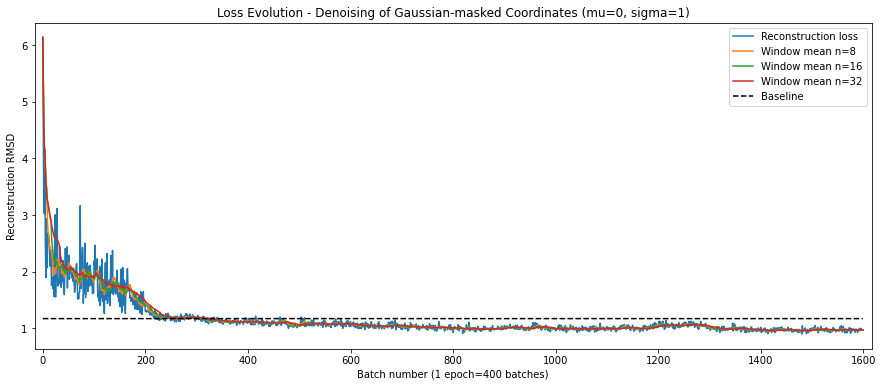

In [13]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(window)] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses)) * np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number (1 epoch=400 batches)")
plt.legend()
plt.show()

### Measure rmsd on (the last trained) reconstructed protein

* Not passing through the model

In [14]:
unfiltered = from_encode_to_pred(x, embedd_info, needed_info=NEEDED_INFO)
# smaple decoded distance test
unfiltered_dec = decode_dist(unfiltered[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
target_dec     = decode_dist(target[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
# mean of diffs is same as diff of means
print("MSE between norms of vecs: ", ((unfiltered_dec - target_dec)**2).mean() ) 
# reconstruct coordinates
target_coords = target[:, :3] * target_dec.unsqueeze(-1)
unfiltered_coords = unfiltered[:, :3] * unfiltered_dec.unsqueeze(-1)
print("MSE between reconstructed coords: ", ((unfiltered_coords - target_coords)**2).mean()**0.5 ) 

MSE between norms of vecs:  tensor(3.5042, device='cuda:0')
MSE between reconstructed coords:  tensor(1.1181, device='cuda:0')


* passing through the model

In [15]:
# smaple decoded distance test
sample_pred_dec = decode_dist(pred[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
target_dec      = decode_dist(target[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
# mean of diffs is same as diff of means
print("MSE between norms of vecs: ", ((sample_pred_dec - target_dec)**2).mean() ) 
# reconstruct coordinates
target_coords = target[:, :3] * target_dec.unsqueeze(-1)
sample_pred_coords = pred[:, :3] * sample_pred_dec.unsqueeze(-1)
print("RMSD between reconstructed coords: ", ((sample_pred_coords - target_coords)**2).mean()**0.5 )

MSE between norms of vecs:  tensor(3.7326, device='cuda:0', grad_fn=<MeanBackward0>)
RMSD between reconstructed coords:  tensor(0.9709, device='cuda:0', grad_fn=<PowBackward0>)
